In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import dill
import numpy as np
import pandas as pd
import scipy.io as io
import datetime
import h5py
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sys.path.append('../helper_functions')
sys.path.append('helper_functions')
sys.path.append('../objects')
sys.path.append('objects')

In [3]:
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from assertion_tests import run_tests
run_tests()

'Success!'

## Feature space scale

In [4]:
dataset = dill.load(open("processed/data-2024_06_05-R_and_C_feature_space/dataset.pkl", "rb"))
leods = h5py.File("processed/data-2024_06_05-R_and_C_feature_space/leods.hdf5",'r')["leods"][:]
responses = h5py.File("processed/data-2024_06_05-R_and_C_feature_space/responses.hdf5",'r')["responses"][:]

In [6]:
leods.shape, responses.shape

((250000, 3, 1005), (250000, 3, 2))

In [7]:
list(dataset.keys())

['worms', 'fish', 'aquarium', 'electric_images']

In [8]:
eis = dataset["electric_images"]["pert"]
aquas = dataset["aquarium"]["dataframe"]
worms = dataset["worms"]["dataframe"]
main_df = eis.join(aquas[["conductivities"]].reset_index(names="aqua_id"), on="aqua_id", rsuffix="_R").join(
    worms[["resistances", "capacitances", "position_ys"]].reset_index(names="worm_id"), on="worm_id", rsuffix="_R"
)

In [9]:
base_feats = dataset["electric_images"]["base"][dataset["electric_images"]["base"]["aqua_id"] == 1]["responses"].iloc[
    0
][1]
feats = responses[main_df[(main_df["aqua_id"] == 1)].index][:,1]
feats_bias = np.array([0, 0])
feats = ((feats + feats_bias) / (base_feats + feats_bias) - 1) * 100

dists = dataset["worms"]["position_ys"][main_df[(main_df["aqua_id"] == 1)]["position_ys"]] - dataset["worms"]["radii"][0] - dataset["fish"]["dataframe"]["objs"][0].get_lateral_semi_axis()
plot_df = pd.DataFrame(np.vstack([feats.T, dists]).T, columns=["mz", "dlz", "distance"])

In [10]:
fig = px.scatter_3d(plot_df, x="mz", y="dlz", z="distance", color="distance", opacity=0.5)
fig.update_traces(marker_size = 1)
fig.update_layout(width=500, height=500)
fig.show()

In [11]:
feature_space_scale = plot_df.groupby("distance").apply(lambda x: pd.Series(x[["mz", "dlz"]].to_numpy().ptp(0))).rename(columns={0: "mz", 1: "dlz"})
feature_space_scale = feature_space_scale.apply(lambda x: x / x.max()).reset_index()

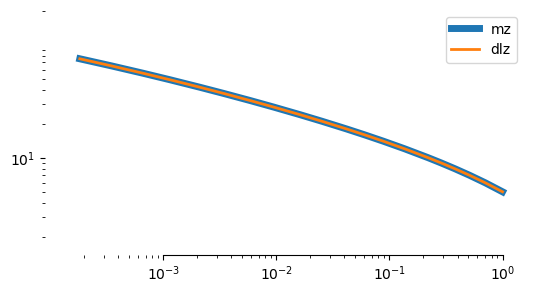

In [15]:
plt.figure(figsize=(6,3))
plt.plot(feature_space_scale["mz"], feature_space_scale["distance"]*1e3, label="mz", lw=5)
plt.plot(feature_space_scale["dlz"], feature_space_scale["distance"]*1e3, label="dlz", lw=2)
plt.legend()
plt.yscale("log")
plt.xscale("log")
sns.despine(offset=10, trim=True)
plt.axis("equal")
plt.show()


## Electric images for fish with chin

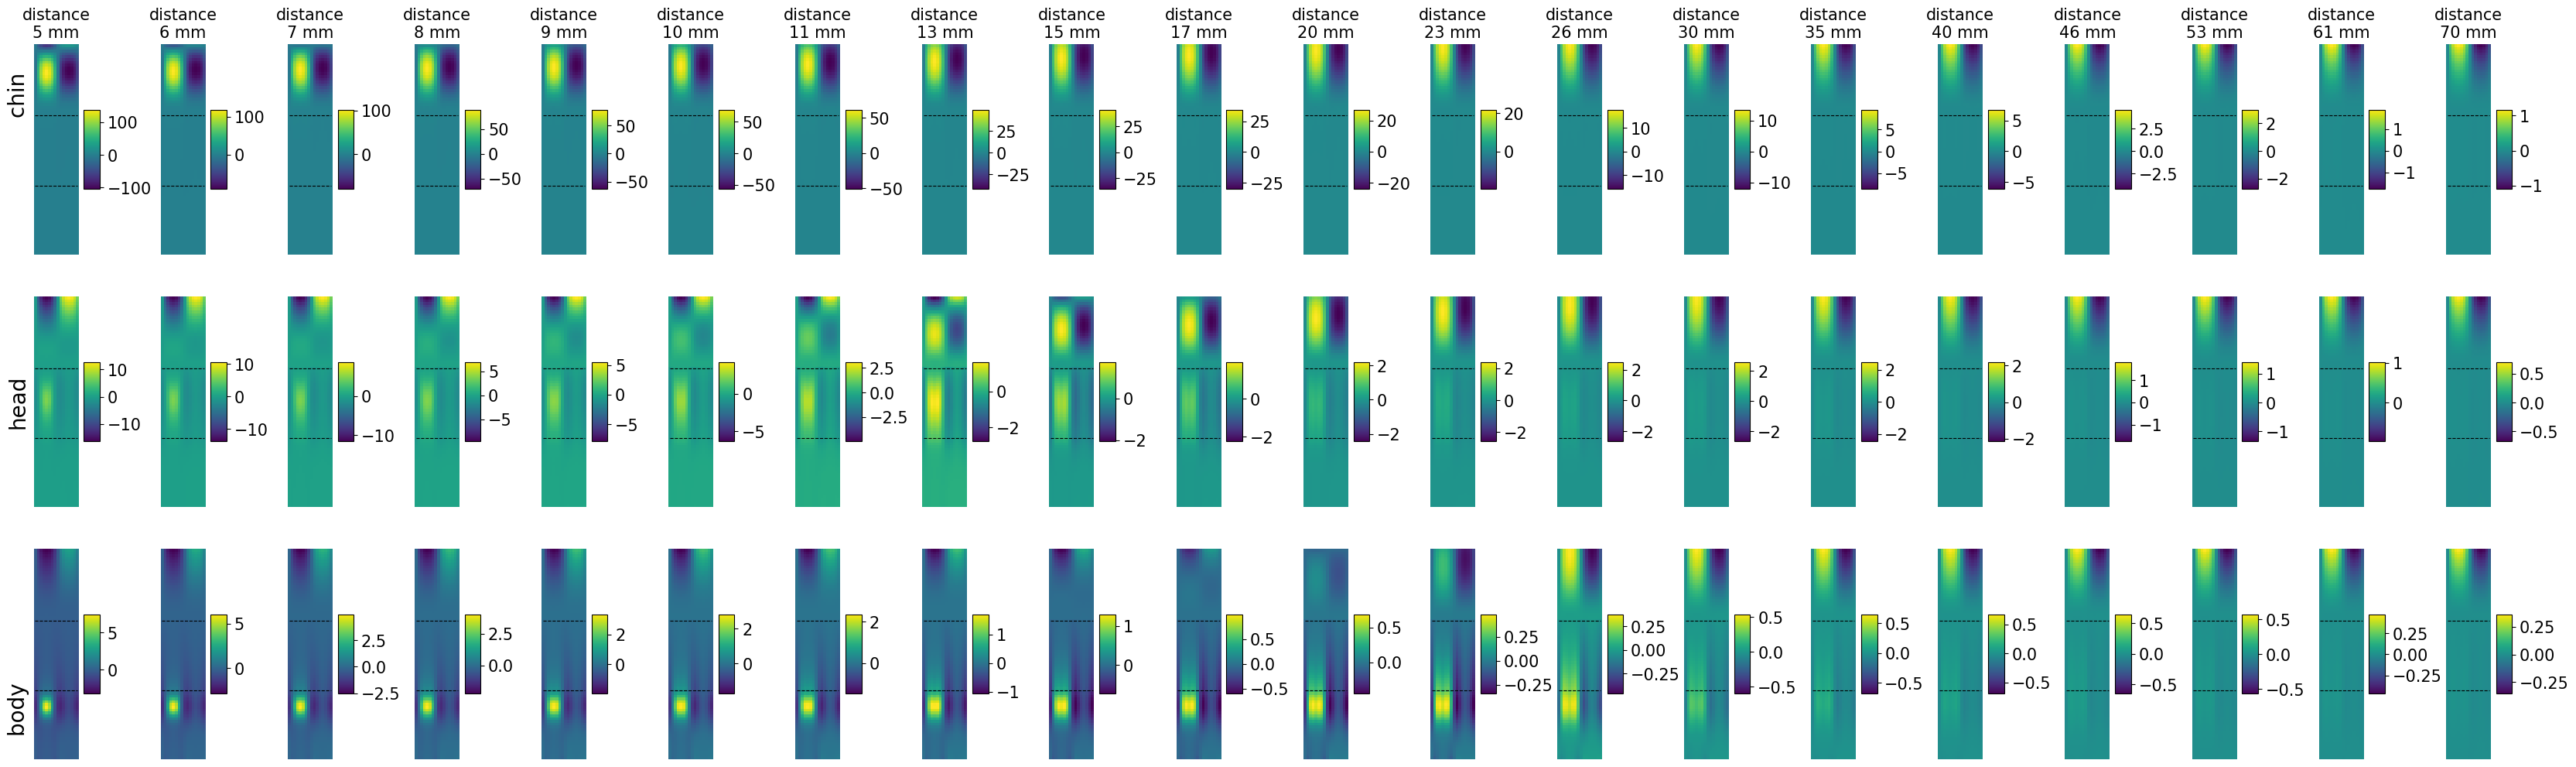

In [14]:
zone = "mz"
dataset_areas = ["chin", "head", "body"]
object_ids = np.arange(20)

zones = dict(mz=0, dlz=1)
f, axes = plt.subplots(3, 20, figsize=(42, 12))  # , gridspec_kw = {'wspace':0.09, 'hspace':-0.95})
for i, dataset_area in enumerate(dataset_areas):
    dataset = dill.load(
        open(f"processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/dataset.pkl", "rb")
    )
    responses = h5py.File(f"processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/responses.hdf5", "r")[
        "responses"
    ][:]
    base_response = dataset["electric_images"]["base"]["responses"][0]

    for j, object_id in enumerate(object_ids):
        selected_response = responses[object_id, :, zones[zone]] / base_response[:, zones[zone]] - 1
        cbar = axes[i, j].imshow(selected_response.reshape(25 * 3, 16) * 100)
        sns.despine(left=True, bottom=True)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].plot([0, 15], [25, 25], "k--", lw=0.8)
        axes[i, j].plot([0, 15], [50, 50], "k--", lw=0.8)
        cbar = plt.colorbar(cbar, shrink=0.5, aspect=5)
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(15)
        if j == 0:
            ylabel = dataset_area
            if dataset_area == "chin":
                ylabel = "                " + dataset_area
            if dataset_area == "body":
                ylabel = dataset_area + "                "
            axes[i, j].set_ylabel(ylabel, fontsize=20)
        if i == 0:
            temp_distance = dataset["worms"]["position_ys"][object_id] * 1e3 - dataset["worms"]["radii"][0] * 1e3 - 1
            axes[i, j].set_title(f"distance\n{temp_distance:.0f} mm", fontsize=15)
plt.show()

## Feature space decay as function of object lateral position

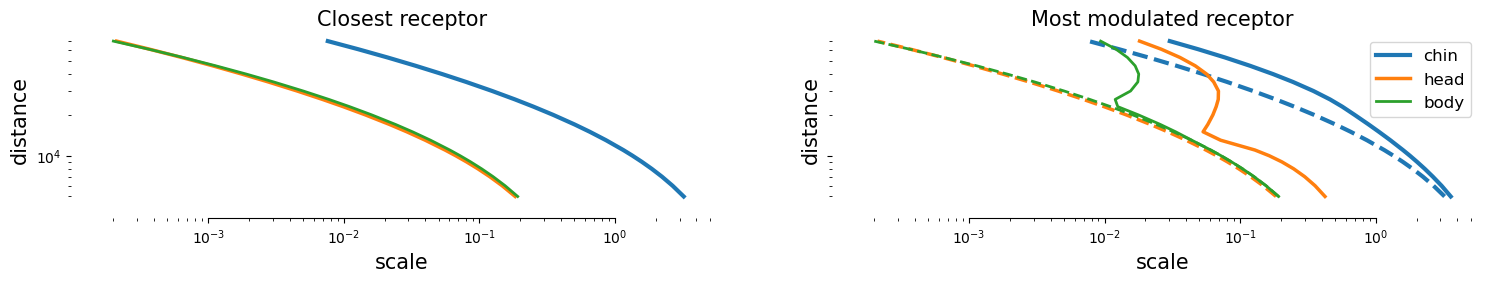

In [13]:
dataset_areas = ["chin", "head", "body"]

f, axes = plt.subplots(1, 2, figsize=(18, 9), sharex=True, sharey=True)
for i, dataset_area in enumerate(dataset_areas):
    dataset = dill.load(
        open(f"processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/dataset.pkl", "rb")
    )
    responses = h5py.File(f"processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/responses.hdf5", "r")[
        "responses"
    ][:]
    base_response = dataset["electric_images"]["base"]["responses"][0]
    responses = responses / base_response - 1

    fish = dataset["fish"]["dataframe"]["objs"][0]
    receptors_locations = fish.get_receptors_locations()
    worm_location = np.array(
        [dataset["worms"]["position_xs"][0], dataset["worms"]["position_ys"][0], dataset["worms"]["position_zs"][0]]
    )
    temp_distance_adjustment = 1
    if dataset_area == "body":
        temp_distance_adjustment = 9
    elif dataset_area == "head":
        temp_distance_adjustment = 7.5
    dists = (
        dataset["worms"]["position_ys"][dataset["worms"]["dataframe"]["position_ys"]] * 1e3
        - dataset["worms"]["radii"][0] * 1e3
        - temp_distance_adjustment
    )

    receptor_id = ((receptors_locations - worm_location) ** 2).sum(1).argmin()
    feats = responses[np.arange(responses.shape[0]), receptor_id]
    plot_df = pd.DataFrame(np.vstack([feats.T, dists]).T, columns=["mz", "dlz", "distance"])
    feature_space_scale = (
        plot_df.groupby("distance")
        .apply(lambda x: pd.Series(x[["mz", "dlz"]].to_numpy().ptp(0)))
        .rename(columns={0: "mz", 1: "dlz"})
    )
    # feature_space_scale = feature_space_scale.apply(lambda x: x / x.max()).reset_index()
    feature_space_scale = feature_space_scale.apply(lambda x: x).reset_index()
    axes[0].plot(feature_space_scale["mz"], feature_space_scale["distance"] * 1e3, lw=3 - i / 2)
    axes[1].plot(feature_space_scale["mz"], feature_space_scale["distance"] * 1e3, lw=3 - i / 2, ls='--')
    axes[0].set_title("Closest receptor", fontsize=15)
    axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].set_xlabel("scale", fontsize=15)
    axes[0].set_ylabel("distance", fontsize=15)
    axes[0].set_aspect("equal")
    sns.despine(offset=10, trim=True)
    
    receptor_id = np.abs(responses[:, :, 0]).argmax(1)
    feats = responses[np.arange(responses.shape[0]), receptor_id]
    plot_df = pd.DataFrame(np.vstack([feats.T, dists]).T, columns=["mz", "dlz", "distance"])
    feature_space_scale = (
        plot_df.groupby("distance")
        .apply(lambda x: pd.Series(x[["mz", "dlz"]].to_numpy().ptp(0)))
        .rename(columns={0: "mz", 1: "dlz"})
    )
    # feature_space_scale = feature_space_scale.apply(lambda x: x / x.max()).reset_index()
    feature_space_scale = feature_space_scale.apply(lambda x: x).reset_index()
    axes[1].plot(feature_space_scale["mz"], feature_space_scale["distance"] * 1e3, label=dataset_area, lw=3 - i / 2, c=f"C{i}")
    axes[1].set_title("Most modulated receptor", fontsize=15)
    axes[1].set_yscale("log")
    axes[1].set_xscale("log")
    axes[1].set_xlabel("scale", fontsize=15)
    axes[1].set_ylabel("distance", fontsize=15)
    axes[1].set_aspect("equal")
    sns.despine(offset=10, trim=True)

plt.legend(fontsize=12)
plt.show()

## Baseline EOD amplitude alongside fish

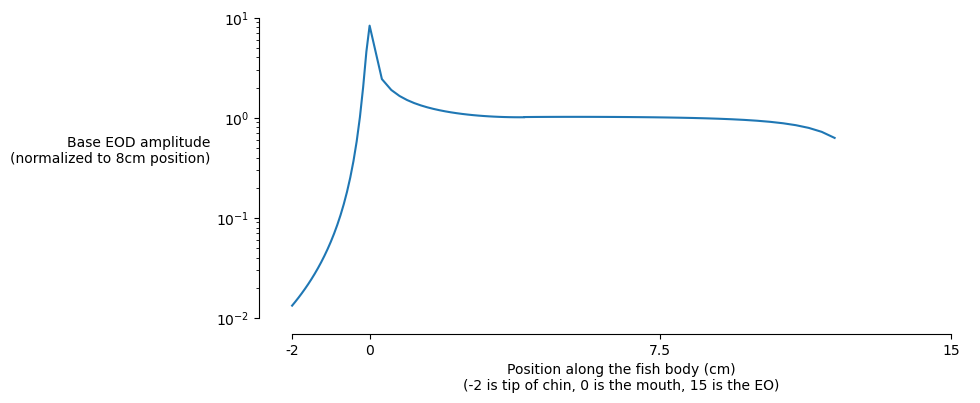

In [14]:
# %matplotlib inline
base_amplitude_avg = base_response[:, 0].reshape(25 * 3, 16).mean(1)
receptor_y_positons = receptors_locations[:, 0].reshape(25 * 3, 16)[:, 0]
plt.figure(figsize=(9, 4))
plt.plot(-receptor_y_positons * 1e2, base_amplitude_avg / base_amplitude_avg[62])
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks([-2, 0, 7.5, 15], [-2, 0, 7.5, 15])
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
plt.yscale("log")
sns.despine(offset=10, trim=True)
plt.show()